In [747]:
import numpy as np
import scienceplots
from matplotlib import pyplot as plt
import matplotlib as mp
import pandas as pd
import os
import scipy as sp
import seaborn as sns
import json
import yaml
import functools
import itertools

In [78]:
prefix='sockperf-eval'
prefix='upload-res2'

In [79]:
res_dir = os.listdir(f'../{prefix}')[0]
res_dir = f"{prefix}/{res_dir}"

In [203]:
def import_pidstat(res_dir):
    pidstat = pd.read_csv(f"../{res_dir}/summary/server/cpu-pidstat.csv")
    pidstat = pidstat[pidstat.used >= 0]
    tmp = pidstat.groupby(['cpu', 'client', 'core', 'timestamp', 'run']).sum(numeric_only=True).reset_index() 
    tmp = tmp.groupby(['cpu', 'client', 'core', 'run']).median(numeric_only=True).reset_index()
    tmp = tmp.groupby(['cpu', 'client', 'core']).median(numeric_only=True).reset_index()
    global_cpu = tmp.groupby(['cpu', 'client']).mean().reset_index()
    return global_cpu, tmp

def import_cpu(res_dir):
    cpu = pd.read_csv(f"../{res_dir}/summary/server/cpu-sar.csv")
    cpu = cpu[cpu.core != -1]
    tmp = cpu.groupby(['cpu', 'client', 'core', 'run']).median().reset_index()
    tmp = cpu.groupby(['cpu', 'client', 'core']).max().reset_index()
    tmp['used'] = 100 - tmp['idle']
    global_cpu = tmp.groupby(['cpu', 'client']).median().reset_index()
    return global_cpu, tmp

def import_latency(res_dir):
    latency = pd.read_csv(f"../{res_dir}/summary/clients/sockperf-1.csv")
    tails = ['99th', '99.9th', '99.99th', '99.999th',]
    cols = ['min', 'median', 'max'] + tails
    latency = latency.groupby(['cpu', 'client', 'run']).median().reset_index()
    latency = latency.groupby(['cpu', 'client']).max().reset_index()
    latency[cols] /= 1000
    return latency

def import_throughput(res_dir):
    net = pd.read_csv(f"../{res_dir}/summary/server/throughput-sar.csv")
    net = net[net.iface == 'wg']
    net = net.groupby(['cpu', 'client', 'run']).median(numeric_only=True).reset_index()
    net = net.groupby(['cpu', 'client',]).max(numeric_only=True).reset_index()
    net['rxkB/s'] = net['rxkB/s'] * 8 / 1e6
    net['txkB/s'] = net['txkB/s'] * 8 / 1e6
    return net

def plot_all(res_dirs, importer, kind='bar', y='used', 
             variants=[0,1], variant_names=['VANILLA', 'CRYPTONCE'], correct=[], 
             ylabel='CPU Usage (in \%)', ylim=None, figsize=(4, 3), ncols=1,
             space=.1, annotate='improvement', annotate_baseline='VANILLA', annotate_variant='CRYPTONCE', 
             fontsize=8, savefig=None, columnspacing=1):
#     vanilla = importer(res_dirs[0][0])
#     cryptonce = importer(res_dirs[1][0])
    baseline = importer(res_dirs[variants[0]][0])
    
    dfs = [importer(res_dirs[i][0]) for i in variants]

    for df_idx, key, val in correct:
        dfs[df_idx].loc[key, y] = val
    
    df = pd.DataFrame()
    df['client'] = dfs[0]['client']
    for df_, name in zip(dfs, variant_names):
        df[name] = df_[y]
    
    df['diff'] = df[annotate_baseline] - df[annotate_variant]
    df['improvement'] = df['diff'] * 100 / df[annotate_baseline]

    with plt.style.context(['science', 'ieee']):
        if kind == 'bar':
            ax = df.plot.bar(x='client', y=variant_names, color=['black', 'red', 'blue', 'green'],
                   grid=True, ylabel=ylabel, ylim=ylim, figsize=figsize, xlabel='Clients')
            plt.xticks(rotation=0)
            
            if annotate is not None:
                for k, i in enumerate(df.index):
                    suffix = "\%" if annotate == "improvement" else ""
                    max_height = df.loc[i, annotate_baseline]  # Position at the higher bar
                    ax.text(k, max_height + space, f'{df.loc[i, annotate]:.2f}{suffix}', 
                            ha='center', fontsize=fontsize)
            
        elif kind == 'line':
            ax = baseline.plot(
                x='client', y=y, grid=True, color='black', marker='x',
                label=variant_names[0], xlabel='Clients', ylabel=ylabel,
            )
            for df_, name in zip(dfs[1:], variant_names[1:]):
                ax = df_.plot(ax=ax, marker='o', figsize=figsize,
                    x='client', y=y, grid=True, color='red',
                    label=name, xlabel='Clients', ylabel=ylabel, ylim=ylim
                )
        plt.legend(loc='upper left', ncol=ncols, columnspacing=columnspacing)
        if savefig is not None:
            plt.savefig(savefig, dpi=400)
        plt.show()
    return df

In [204]:
def reslv_res_name(res_dir):
    filename = f"../{res_dir}/EXPERIMENT_DATA/TEST_CONFIG"    
    with open(filename) as file:
        test_config = file.read().strip()
    
    yaml_file = f"../{res_dir}/EXPERIMENT_DATA/{test_config}.yaml"
    with open(yaml_file) as file:
        content = yaml.load(file, yaml.FullLoader)
        flow = content['all']['vars']['bandwidth']
    
    if test_config != 'default':
        use_case, suffix = test_config.split('--')
        crypted = suffix.split('-')[0]
        threaded = "-".join(suffix.split('-')[1:])
#         threaded = len(suffix.split('-')[1:]) == 2
    else:
        use_case = wg_variant = traffic = flow = None
        
    return test_config, use_case, flow, crypted, threaded

In [205]:
res_dirs = [(f"{prefix}/{e}", *reslv_res_name(f"{prefix}/{e}")) 
            for e in os.listdir(f"../{prefix}") if e.startswith("results-")]

In [206]:
# 1. find yes and put it at start
# 2. find no and put it at second

def find_index(res_dirs, val):
    for k, res in enumerate(res_dirs):
        if res[4] == val:
            return k

def print_tab(tab):
    for i in tab:
        print(i)

In [207]:
prefix='res'
try:
    os.makedirs(f"../graphs/{prefix}")
except:
    pass
res_dirs = [(f"{prefix}/{e}", *reslv_res_name(f"{prefix}/{e}")) 
            for e in os.listdir(f"../{prefix}") if e.startswith("results-")]
# index = find_index(res_dirs, 'yes')
# yes = res_dirs.pop(index)
# res_dirs.insert(0, yes)
print_tab(enumerate(res_dirs))

(0, ('res/results-bcf87c30', 'upload--partial-kernel-v3', 'upload', '150Mbits', 'partial', 'kernel-v3'))
(1, ('res/results-10af234a', 'upload--partial-kernel-v3-bp', 'upload', '150Mbits', 'partial', 'kernel-v3-bp'))
(2, ('res/results-3a8a6d32', 'upload--partial-kernel-v1', 'upload', '150Mbits', 'partial', 'kernel-v1'))
(3, ('res/results-5bf7322e', 'upload--yes-kernel-v1', 'upload', '150Mbits', 'yes', 'kernel-v1'))
(4, ('res/results-729a4dc0', 'upload--partial-kernel-v1-check-port', 'upload', '150Mbits', 'partial', 'kernel-v1-check-port'))
(5, ('res/results-44a5170c', 'upload--yes-kernel-v3', 'upload', '150Mbits', 'yes', 'kernel-v3'))
(6, ('res/results-f6cbf2f9', 'upload--yes-kernel-v3-bp', 'upload', '150Mbits', 'yes', 'kernel-v3-bp'))


In [208]:
def pidstat_importer(res_dir):
    return import_pidstat(res_dir)[0]

def cpu_importer(res_dir):
    return import_cpu(res_dir)[0]

In [209]:
names = {
    'yes': 'VANILLA',
    'partial': 'CRYPTONCE',
}
variants=[3, 4]
variant_names=['VANILLA', "CRYPTONCE"]
annotate_variant='CRYPTONCE'

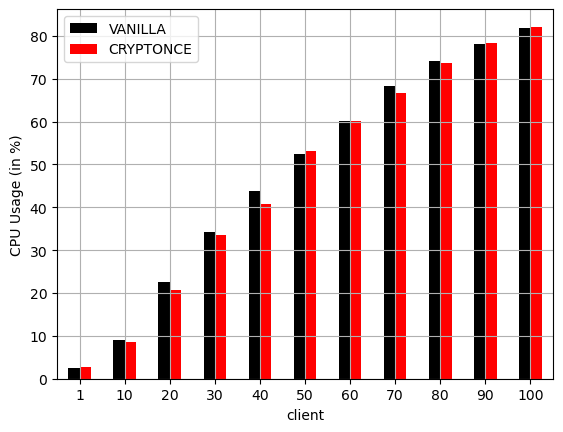

,client,VANILLA,CRYPTONCE,diff,improvement
0,1,2.0,1.0,1.0,50.000000
1,10,8.0,1.0,7.0,87.500000
2,20,15.0,1.0,14.0,93.333333
3,30,25.5,1.0,24.5,96.078431
4,40,33.0,1.0,32.0,96.969697
5,50,42.0,1.0,41.0,97.619048
6,60,49.0,1.0,48.0,97.959184
7,70,56.0,1.0,55.0,98.214286
8,80,64.0,1.0,63.0,98.437500
9,90,70.0,1.0,69.0,98.571429


In [199]:
plot_all(res_dirs, cpu_importer)

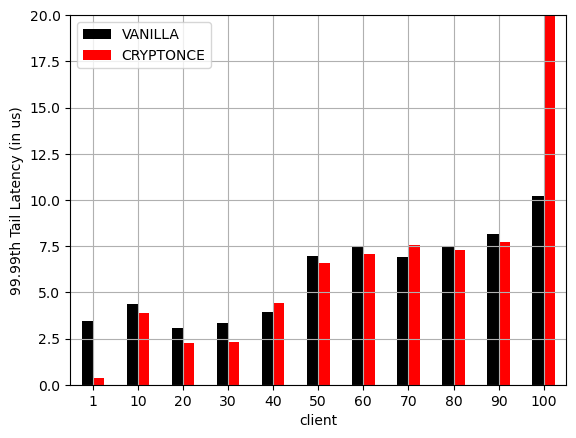

In [200]:
plot_all(res_dirs, import_latency, y='99th',
#               correct=[(0, 10, 0.69)],
              variants=variants, variant_names=variant_names,
              annotate_variant=annotate_variant,
              fontsize=7, space=.01,
#               correct=[(0, 10, 0.65), (1, 10, 0.64)],
              figsize=(5, 3), ylim=[0, 1],
              ylabel='99th Tail Latency (in us)', 
#               savefig="../graphs/latency_sockperf.pdf",
              savefig=None,
             )

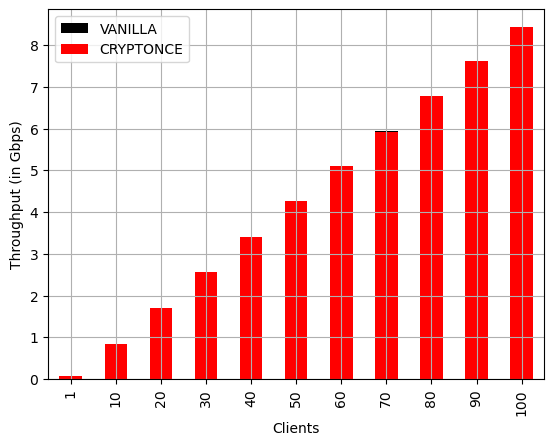

,client,VANILLA,CRYPTONCE,diff,improvement
0,1,0.085154,0.085157,-0.000002,-0.002584
1,10,0.851479,0.851389,0.000090,0.010570
2,20,1.703086,1.703148,-0.000062,-0.003619
3,30,2.554656,2.554680,-0.000024,-0.000946
4,40,3.403890,3.403927,-0.000036,-0.001068
5,50,4.253075,4.251746,0.001329,0.031253
6,60,5.093228,5.092383,0.000846,0.016601
7,70,5.928778,5.926107,0.002671,0.045059
8,80,6.774180,6.770464,0.003716,0.054861
9,90,7.601888,7.595294,0.006594,0.086748


In [202]:
plot_all(res_dirs, import_throughput,  kind='line', y='rxkB/s', 
         variants=variants, variant_names=variant_names,
         annotate_variant=annotate_variant,
#          annotate_variant='CRYPTONCE-BATCH2',
         ylabel='Throughput (in Gbps)', figsize=(5, 2.7),)

In [251]:
res_dirs

[('res2/results-841258a9',
  'upload--yes-kernel-v1',
  'upload',
  '150Mbits',
  'yes',
  'kernel-v1'),
 ('res2/results-736b682b',
  'upload--partial-kernel-v1',
  'upload',
  '150Mbits',
  'partial',
  'kernel-v1')]